In [2]:
import os
fname = os.path.join("jena_climate_2009_2016.csv")

with open(fname) as f:
    data = f.read()


In [3]:
lines = data.split("\n")
header = lines[0].split(",")
lines = lines[1:]
print(header)
print(len(lines))


['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [4]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(",")[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]


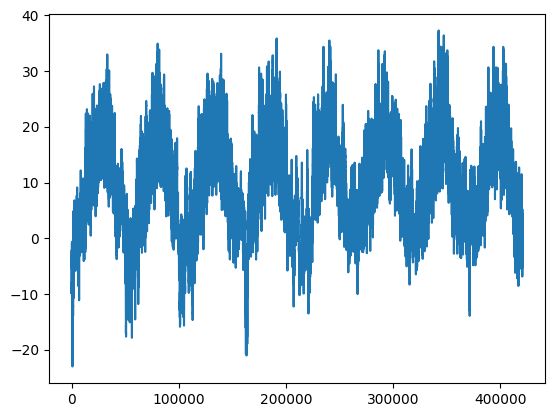

In [5]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
#Plotting the first 10 days of the temperature timeseries


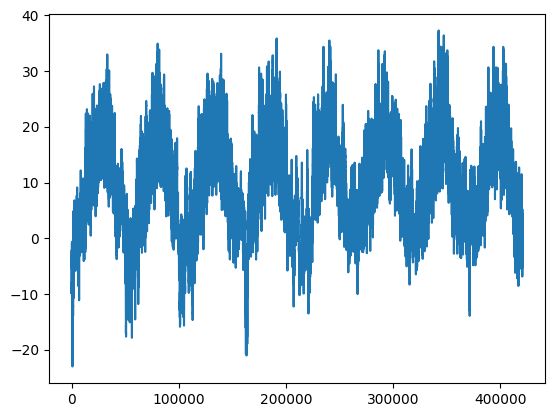

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(temperature)), temperature)
#Plotting the first 10 days of the temperature timeseries


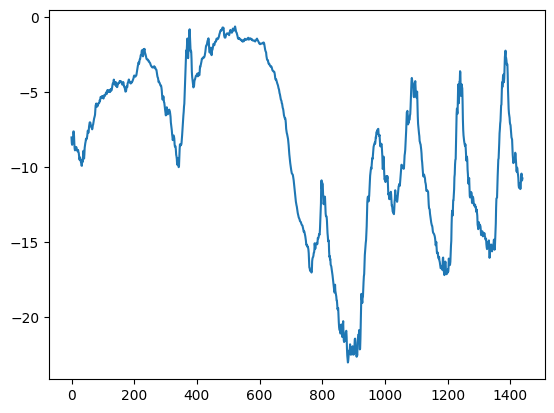

In [7]:
plt.plot(range(1440), temperature[:1440])



#Computing the number of samples we'll use for each data split

In [8]:
num_train_samples = int(0.5 * len(raw_data))
num_val_samples = int(0.25 * len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)
#Preparing the data
#Normalizing the data


num_train_samples: 210225
num_val_samples: 105112
num_test_samples: 105114


In [9]:
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std
import numpy as np
from tensorflow import keras
int_sequence = np.arange(10)
dummy_dataset = keras.utils.timeseries_dataset_from_array(
    data=int_sequence[:-3],
    targets=int_sequence[3:],
    sequence_length=3,
    batch_size=2,)


In [10]:
for inputs, targets in dummy_dataset:
    for i in range(inputs.shape[0]):
        print([int(x) for x in inputs[i]], int(targets[i]))


[0, 1, 2] 3
[1, 2, 3] 4
[2, 3, 4] 5
[3, 4, 5] 6
[4, 5, 6] 7


Instantiating datasets for training, validation, and testing



In [11]:
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length + 24 - 1)
batch_size = 256


In [12]:
train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)


In [13]:
val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)


In [14]:

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)


Inspecting the output of one of our datasets

In [15]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break


samples shape: (256, 120, 14)
targets shape: (256,)


A common-sense, non-machine-learning baseline
Computing the common-sense baseline MAE


In [16]:
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen

print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")


Validation MAE: 2.44
Test MAE: 2.62


In [21]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint("jena_dense.x",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_dense.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 49s 59ms/step - loss: 12.3061 - mae: 2.7076 - val_loss: 9.9222 - val_mae: 2.4893
Epoch 2/10
819/819 [==============================] - 40s 48ms/step - loss: 8.9908 - mae: 2.3573 - val_loss: 10.0459 - val_mae: 2.5097
Epoch 3/10
819/819 [==============================] - 39s 47ms/step - loss: 8.3113 - mae: 2.2697 - val_loss: 10.4840 - val_mae: 2.5609
Epoch 4/10
819/819 [==============================] - 48s 58ms/step - loss: 7.8699 - mae: 2.2099 - val_loss: 10.7913 - val_mae: 2.6012
Epoch 5/10
819/819 [==============================] - 41s 50ms/step - loss: 7.5466 - mae: 2.1631 - val_loss: 10.4208 - val_mae: 2.5589
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 7.2810 - mae: 2.1240 - val_loss: 10.8254 - val_mae: 2.6079
Epoch 7/10
819/819 [==============================] - 49s 59ms/step - loss: 7.0879 - mae: 2.0949 - val_loss: 12.0286 - val_mae: 2.7295
Epoch 8/10
819/819 [==============================] - 4

Plotting results

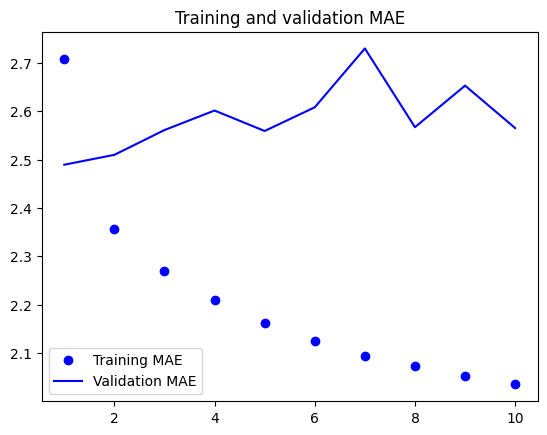

In [22]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()


Let's try a 1D convolutional model

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation="relu")(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation="relu")(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation="relu")(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_conv.x",
                                    save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_conv.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 42s 50ms/step - loss: 22.8747 - mae: 3.6768 - val_loss: 16.9087 - val_mae: 3.2743
Epoch 2/10
819/819 [==============================] - 51s 63ms/step - loss: 14.6589 - mae: 3.0357 - val_loss: 14.8678 - val_mae: 3.0303
Epoch 3/10
819/819 [==============================] - 41s 50ms/step - loss: 13.3119 - mae: 2.8847 - val_loss: 16.1709 - val_mae: 3.2039
Epoch 4/10
819/819 [==============================] - 41s 49ms/step - loss: 12.4144 - mae: 2.7824 - val_loss: 14.5622 - val_mae: 2.9968
Epoch 5/10
819/819 [==============================] - 40s 49ms/step - loss: 11.7489 - mae: 2.7093 - val_loss: 14.9256 - val_mae: 3.0543
Epoch 6/10
819/819 [==============================] - 50s 61ms/step - loss: 11.2951 - mae: 2.6587 - val_loss: 15.5429 - val_mae: 3.0826
Epoch 7/10
819/819 [==============================] - 50s 61ms/step - loss: 10.9269 - mae: 2.6162 - val_loss: 17.2103 - val_mae: 3.3098
Epoch 8/10
819/819 [============================

A first recurrent baseline
A simple LSTM-based model


In [26]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm.x",
                                    save_best_only=True)]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 85s 59ms/step - loss: 48.7398 - mae: 5.1125 - val_loss: 14.2448 - val_mae: 2.8464
Epoch 2/10
819/819 [==============================] - 56s 68ms/step - loss: 11.4356 - mae: 2.6133 - val_loss: 9.6617 - val_mae: 2.4213
Epoch 3/10
819/819 [==============================] - 54s 66ms/step - loss: 9.9156 - mae: 2.4535 - val_loss: 9.6596 - val_mae: 2.4159
Epoch 4/10
819/819 [==============================] - 46s 55ms/step - loss: 9.3639 - mae: 2.3801 - val_loss: 9.6200 - val_mae: 2.4150
Epoch 5/10
819/819 [==============================] - 48s 58ms/step - loss: 8.9760 - mae: 2.3315 - val_loss: 9.6030 - val_mae: 2.4083
Epoch 6/10
819/819 [==============================] - 43s 52ms/step - loss: 8.6892 - mae: 2.2947 - val_loss: 9.6670 - val_mae: 2.4158
Epoch 7/10
819/819 [==============================] - 44s 53ms/step - loss: 8.4366 - mae: 2.2621 - val_loss: 9.6633 - val_mae: 2.4160
Epoch 8/10
819/819 [==============================] - 56s 6

Understanding recurrent neural networks
NumPy implementation of a simple RNN


In [18]:
import numpy as np
timesteps = 100
input_features = 32
output_features = 64
inputs = np.random.random((timesteps, input_features))
state_t = np.zeros((output_features,))
W = np.random.random((output_features, input_features))
U = np.random.random((output_features, output_features))
b = np.random.random((output_features,))
successive_outputs = []
for input_t in inputs:
    output_t = np.tanh(np.dot(W, input_t) + np.dot(U, state_t) + b)
    successive_outputs.append(output_t)
    state_t = output_t
final_output_sequence = np.stack(successive_outputs, axis=0)


A recurrent layer in Keras
An RNN layer that can process sequences of any length


In [19]:
num_features = 14
inputs = keras.Input(shape=(None, num_features))
outputs = layers.SimpleRNN(16)(inputs)

num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=False)(inputs)
print(outputs.shape)

(None, 16)


An RNN layer that returns its full output sequence

In [20]:
num_features = 14
steps = 120
inputs = keras.Input(shape=(steps, num_features))
outputs = layers.SimpleRNN(16, return_sequences=True)(inputs)
print(outputs.shape)


(None, 120, 16)


Stacking RNN layers

Advanced use of recurrent neural networks
Using recurrent dropout to fight overfitting
Training and evaluating a dropout-regularized LSTM


In [35]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(16, return_sequences=True)(inputs)
x = layers.SimpleRNN(16, return_sequences=True)(x)
outputs = layers.SimpleRNN(16)(x)

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)

model = keras.models.load_model("jena_lstm_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")


Epoch 1/10
819/819 [==============================] - 443s 536ms/step - loss: 29.8913 - mae: 4.0102 - val_loss: 9.7227 - val_mae: 2.4021
Epoch 2/10
819/819 [==============================] - 396s 484ms/step - loss: 14.8556 - mae: 2.9900 - val_loss: 9.2134 - val_mae: 2.3569
Epoch 3/10
819/819 [==============================] - 399s 487ms/step - loss: 13.9043 - mae: 2.8870 - val_loss: 9.1096 - val_mae: 2.3425
Epoch 4/10
819/819 [==============================] - 395s 482ms/step - loss: 13.3090 - mae: 2.8227 - val_loss: 9.2788 - val_mae: 2.3676
Epoch 5/10
819/819 [==============================] - 386s 471ms/step - loss: 12.8801 - mae: 2.7794 - val_loss: 9.5539 - val_mae: 2.3960
Epoch 6/10
819/819 [==============================] - 386s 471ms/step - loss: 12.4423 - mae: 2.7336 - val_loss: 9.2533 - val_mae: 2.3577
Epoch 7/10
819/819 [==============================] - 385s 470ms/step - loss: 12.0510 - mae: 2.6927 - val_loss: 9.3469 - val_mae: 2.3543
Epoch 8/10
819/819 [=====================

405/405 [==============================] - 27s 65ms/step - loss: 10.5102 - mae: 2.5521
Test MAE: 2.55


In [ ]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(32, return_sequences=True)(x)
outputs = layers.SimpleRNN(32)(x)

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)


Epoch 1/10
819/819 [==============================] - 386s 467ms/step - loss: 26.2338 - mae: 3.7962 - val_loss: 9.5193 - val_mae: 2.4028
Epoch 2/10
819/819 [==============================] - 391s 477ms/step - loss: 14.7799 - mae: 2.9877 - val_loss: 9.3490 - val_mae: 2.3720
Epoch 3/10
819/819 [==============================] - 390s 476ms/step - loss: 13.8362 - mae: 2.8903 - val_loss: 9.4149 - val_mae: 2.3773
Epoch 4/10
819/819 [==============================] - 377s 460ms/step - loss: 13.2766 - mae: 2.8283 - val_loss: 9.2943 - val_mae: 2.3761
Epoch 5/10
819/819 [==============================] - 370s 452ms/step - loss: 12.8246 - mae: 2.7790 - val_loss: 9.2635 - val_mae: 2.3650
Epoch 6/10
819/819 [==============================] - 362s 442ms/step - loss: 12.4706 - mae: 2.7382 - val_loss: 9.4600 - val_mae: 2.3937
Epoch 7/10
819/819 [==============================] - 362s 442ms/step - loss: 12.0961 - mae: 2.6949 - val_loss: 9.5720 - val_mae: 2.4061
Epoch 8/10
819/819 [=====================

In [37]:
model = keras.models.load_model("jena_lstm_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

405/405 [==============================] - 33s 80ms/step - loss: 10.5222 - mae: 2.5677
Test MAE: 2.57


In [21]:
inputs = keras.Input(shape=(steps, num_features))
x = layers.SimpleRNN(32, return_sequences=True)(inputs)
x = layers.SimpleRNN(64, return_sequences=True)(inputs)
x = layers.SimpleRNN(128, return_sequences=True)(x)
outputs = layers.SimpleRNN(64)(x)

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [keras.callbacks.ModelCheckpoint("jena_lstm_dropout.x",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks=callbacks)
inputs = keras.Input(shape=(sequence_length, num_features))
x = layers.LSTM(32, recurrent_dropout=0.2, unroll=True)(inputs)


model = keras.models.load_model("jena_lstm_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 222s 265ms/step - loss: 28.6350 - mae: 3.9348 - val_loss: 9.5478 - val_mae: 2.4019
Epoch 2/10
819/819 [==============================] - 217s 265ms/step - loss: 14.6697 - mae: 2.9735 - val_loss: 9.1730 - val_mae: 2.3601
Epoch 3/10
819/819 [==============================] - 215s 262ms/step - loss: 13.5998 - mae: 2.8592 - val_loss: 9.0115 - val_mae: 2.3311
Epoch 4/10
819/819 [==============================] - 201s 245ms/step - loss: 13.0243 - mae: 2.8019 - val_loss: 9.3008 - val_mae: 2.3673
Epoch 5/10
819/819 [==============================] - 203s 248ms/step - loss: 12.4835 - mae: 2.7395 - val_loss: 8.9989 - val_mae: 2.3357
Epoch 6/10
819/819 [==============================] - 202s 246ms/step - loss: 12.1886 - mae: 2.7093 - val_loss: 9.2329 - val_mae: 2.3587
Epoch 7/10
819/819 [==============================] - 214s 260ms/step - loss: 11.8765 - mae: 2.6746 - val_loss: 9.0957 - val_mae: 2.3414
Epoch 8/10
819/819 [=====================

Stacking recurrent layers
Training and evaluating a dropout-regularized, stacked GRU model


In [22]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.LSTM(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.x",
                                    save_best_only=True)]


model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    val idation_data=val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model("jena_stacked_gru_dropout.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 404s 486ms/step - loss: 27.1085 - mae: 3.8391 - val_loss: 9.8991 - val_mae: 2.4320
Epoch 2/10
819/819 [==============================] - 427s 522ms/step - loss: 13.8598 - mae: 2.8863 - val_loss: 9.6580 - val_mae: 2.4229
Epoch 3/10
819/819 [==============================] - 430s 525ms/step - loss: 12.7258 - mae: 2.7640 - val_loss: 9.8142 - val_mae: 2.4307
Epoch 4/10
819/819 [==============================] - 423s 516ms/step - loss: 11.9143 - mae: 2.6737 - val_loss: 9.8321 - val_mae: 2.4427
Epoch 5/10
819/819 [==============================] - 426s 520ms/step - loss: 11.1161 - mae: 2.5843 - val_loss: 10.4112 - val_mae: 2.5057
Epoch 6/10
819/819 [==============================] - 388s 474ms/step - loss: 10.5720 - mae: 2.5206 - val_loss: 10.7496 - val_mae: 2.5209
Epoch 7/10
819/819 [==============================] - 386s 471ms/step - loss: 10.0432 - mae: 2.4544 - val_loss: 11.1290 - val_mae: 2.5474
Epoch 8/10
819/819 [==================

Using bidirectional RNNs
Training and evaluating a bidirectional LSTM


In [23]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(64))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [keras.callbacks.ModelCheckpoint("jena_bidirectional_lstm.x",
                                    save_best_only=True)]

model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset,
                    callbacks = callbacks)

model = keras.models.load_model("jena_bidirectional_lstm.x")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 [==============================] - 450s 545ms/step - loss: 12.7907 - mae: 2.6717 - val_loss: 10.2163 - val_mae: 2.4645
Epoch 2/10
819/819 [==============================] - 436s 532ms/step - loss: 6.7654 - mae: 2.0231 - val_loss: 10.9328 - val_mae: 2.5797
Epoch 3/10
819/819 [==============================] - 439s 536ms/step - loss: 4.8892 - mae: 1.7165 - val_loss: 11.5844 - val_mae: 2.6620
Epoch 4/10
819/819 [==============================] - 440s 537ms/step - loss: 3.7326 - mae: 1.4947 - val_loss: 12.9856 - val_mae: 2.8169
Epoch 5/10
819/819 [==============================] - 432s 527ms/step - loss: 3.0338 - mae: 1.3440 - val_loss: 13.0017 - val_mae: 2.8166
Epoch 6/10
819/819 [==============================] - 455s 556ms/step - loss: 2.4680 - mae: 1.2106 - val_loss: 13.1607 - val_mae: 2.8544
Epoch 7/10
819/819 [==============================] - 446s 544ms/step - loss: 2.0852 - mae: 1.1106 - val_loss: 14.1185 - val_mae: 2.9548
Epoch 8/10
819/819 [====================

Going even further
Summary
# Deep learning for timeseries
Cell Tags
Add Tag
Raw NBConvert Format

Slide Type

Advanced Tools

Simple
0
5
Python 3 | Idle
Saving failed
chapter10_dl-for-timeseries.ipynb
Ln 1, Col 1
Mode: Command
